In [2]:
import pandas as pd
import numpy as np

#from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizerFast as RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, AUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.0.0+cu117
True


In [4]:
print(torch.__version__)

2.0.0+cu117


In [5]:
df = pd.read_csv("Archive\\clean_data.csv").drop(columns=['Unnamed: 0', 'comment_length', 'id'])
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_flag
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,daww matches background colour im seemingly st...,0,0,0,0,0,0,0
2,hey man im really trying edit war guy constant...,0,0,0,0,0,0,0
3,make real suggestions improvement wondered sec...,0,0,0,0,0,0,0
4,sir hero chance remember page thats,0,0,0,0,0,0,0


In [6]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_labels = len(LABEL_COLUMNS)
print('Label columns: ', LABEL_COLUMNS)

Label columns:  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df['one_hot_labels'] = list(df[LABEL_COLUMNS].values)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_flag,one_hot_labels
0,featured article think links incorporated feat...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,read article,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,article interesting reasons trying promote con...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,dyk nom know updated article lucy jane bledsoe...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,want ill try refactor page removing gts remark...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [8]:
df.shape

(142695, 9)

In [9]:
df = pd.concat([df[df['toxic_flag'] == 1], df[df['toxic_flag'] == 0].sample((70000 - df[df['toxic_flag'] == 1]['toxic_flag'].sum()), random_state=42)]).drop(columns='toxic_flag').reset_index(drop=True)

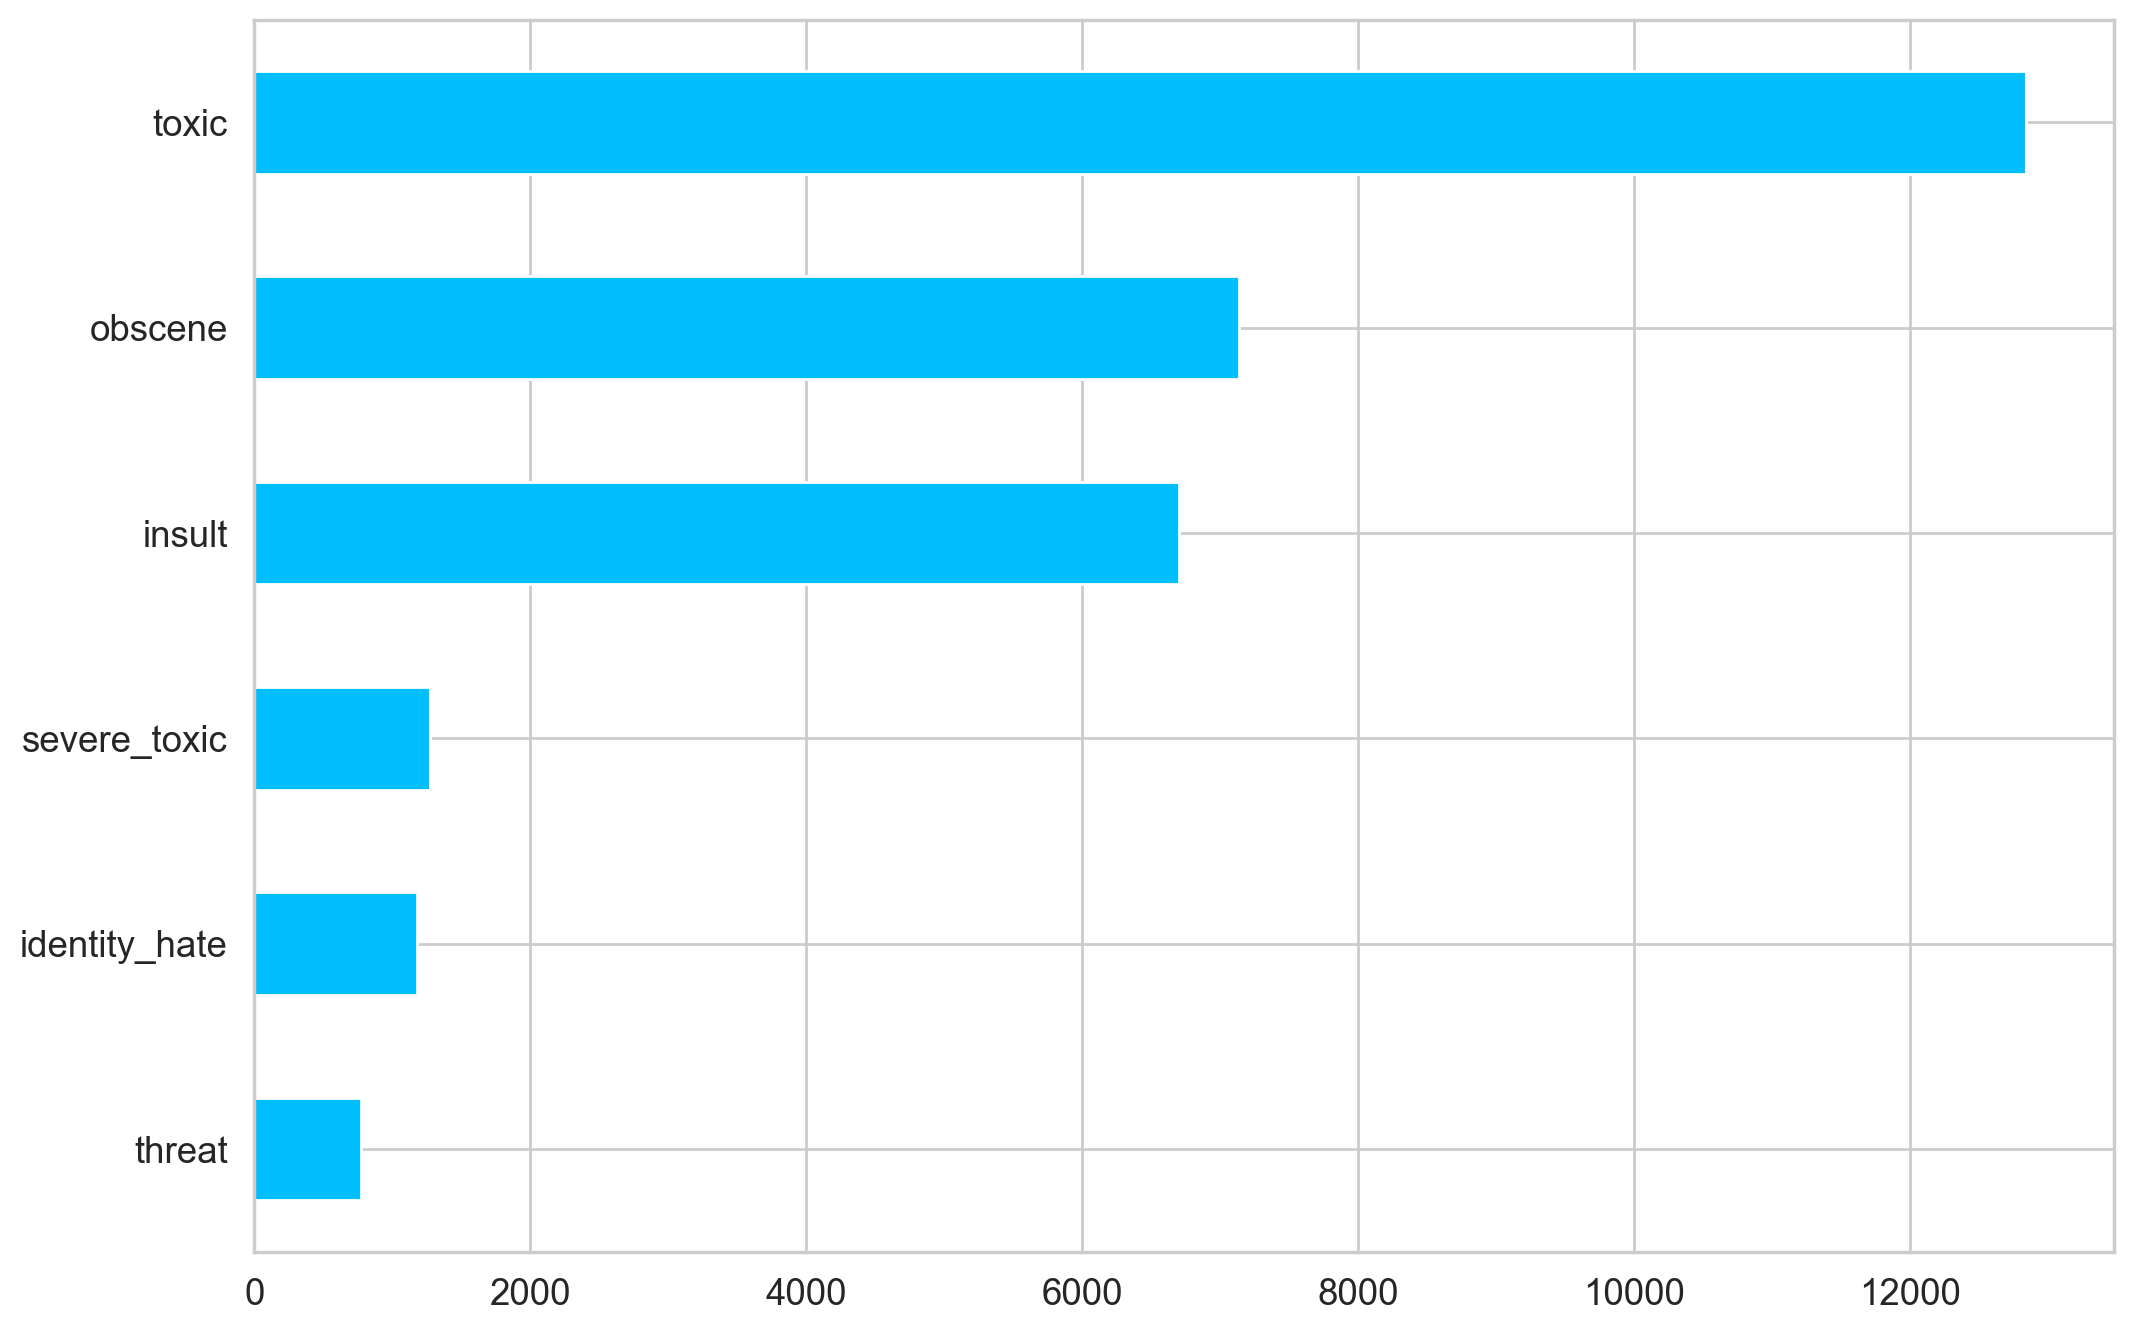

In [10]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")
plt.show()

In [11]:
df['strat_label'] = df['one_hot_labels'].apply(lambda x: '-'.join(map(str, x)))

# Check distribution of stratification labels
label_counts = df['strat_label'].value_counts()
print("Class distribution:\n", label_counts)

# If any class has only 1 instance, consider handling it:
if (label_counts < 2).any():
    print("Warning: At least one class has fewer than 2 instances.")

    # Option 1: Randomly split without stratification
    from sklearn.model_selection import train_test_split

    strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, random_state=42)

else:
    # Initialize StratifiedShuffleSplit if all classes are valid
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Apply stratified split
    for train_index, test_index in sss.split(df, df['strat_label']):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]

Class distribution:
 strat_label
0-0-0-0-0-0    56295
1-0-0-0-0-0     4771
1-0-1-0-1-0     3149
1-0-1-0-0-0     1415
1-0-0-0-1-0      999
1-1-1-0-1-0      760
1-0-1-0-1-1      479
0-0-1-0-0-0      280
0-0-0-0-1-0      273
1-0-1-1-1-0      236
1-1-1-0-1-1      197
0-0-1-0-1-0      165
1-0-0-1-0-0      134
1-0-1-1-1-1      123
1-1-1-0-0-0      105
1-0-0-0-0-1       91
1-1-1-1-1-0       91
1-0-0-0-1-1       88
1-1-1-1-1-1       58
0-0-0-0-0-1       50
0-0-0-1-0-0       43
1-1-0-0-0-0       29
1-0-1-0-0-1       26
0-0-0-0-1-1       26
1-0-0-1-1-0       17
1-1-0-1-0-0       15
0-0-1-0-1-1       15
1-0-1-1-0-0       15
1-0-0-1-0-1       12
1-1-0-0-1-0        7
0-0-1-1-1-0        6
0-0-1-1-0-0        6
1-0-0-1-1-1        5
1-1-1-1-0-0        4
1-1-0-1-1-0        3
0-0-1-0-0-1        3
1-1-0-1-0-1        3
1-1-1-0-0-1        2
0-0-0-1-1-0        2
1-1-0-0-1-1        1
1-1-0-0-0-1        1
Name: count, dtype: int64


In [12]:
val_df = strat_test_set
train_df = strat_train_set

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [14]:
MAX_TOKEN_COUNT = 128
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, clean_up_tokenization_spaces=True)

In [15]:
def sampler_dataloader_creation(batch_size, df, tokenizer, label_columns, sampler='Sequential'):
    """ Convert a DataFrame into a PyTorch DataLoader. """

    # Extract the relevant columns
    inputs = df['comment_text'].tolist()
    labels = df[label_columns].values.tolist()  # Convert to list
    masks = df['one_hot_labels'].tolist()

    # Tokenize the inputs
    encoding = tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')  # Use 'pt' for PyTorch tensors

    # Convert labels and masks to tensors
    labels = torch.tensor(labels, dtype=torch.float32)
    masks = torch.tensor(np.array(masks))  # Convert to NumPy array first

    # Create a TensorDataset and DataLoader
    data = TensorDataset(
        encoding['input_ids'],
        encoding['attention_mask'],
        masks,
        labels
    )
    
    if sampler == 'Sequential':
        sampler = SequentialSampler(data)
    elif sampler == 'Random':
        sampler = RandomSampler(data)

    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return dataloader

# Example usage
#train_dataloader = sampler_dataloader_creation(BATCH_SIZE, train_df, tokenizer, label_columns=LABEL_COLUMNS, sampler='Sequential')


In [16]:
#train_dataloader = sampler_dataloader_creation(BATCH_SIZE, train_df, tokenizer, sampler='Sequential')
#validation_dataloader = sampler_dataloader_creation(BATCH_SIZE, val_df, tokenizer, label_columns=LABEL_COLUMNS, sampler='Sequential')
#sampler_dataloader_creation(BATCH_SIZE, val_df, tokenizer, sampler='Random')


# torch.save(validation_dataloader, 'validation_data_loader')
# torch.save(train_dataloader, 'train_data_loader')

In [17]:
val_df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'one_hot_labels', 'strat_label'],
      dtype='object')

In [18]:
# Class weights calculation
class_counts = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().to_list()
total_count = df.shape[0]
class_weights = [total_count / count if count > 0 else 0 for count in class_counts]
class_weights = np.array(class_weights) / np.sum(class_weights)
class_weights_tensor = torch.FloatTensor(class_weights)

class_weights_tensor = torch.FloatTensor(class_weights)

# CHARTGPT

Great! The shapes of the logits and labels now match, both being [16, 6]. This indicates that your model is correctly set up for multi-label classification.

Next Steps
* Loss Calculation: Since the shapes are correct, the model should be able to compute the loss without issues. If you still encounter errors, please check the following:

* Ensure that there are no NaN or Inf values in either the logits or labels.
* Make sure the loss function (BCEWithLogitsLoss) is correctly applied.
* Training Output: As the training proceeds, monitor the loss values printed in the logs. If they appear reasonable, it means the training is on the right track.

* Evaluate Training Performance: After training completes, you might want to evaluate your model's performance on a validation dataset to ensure it's learning effectively.

Possible Improvements
* Early Stopping: Consider implementing early stopping if you notice the training loss decreasing but the validation loss not improving.

* Learning Rate Scheduler: Adding a learning rate scheduler can help improve convergence.

* Model Checkpoints: Use checkpoints to save the best model based on validation performance.

* Hyperparameter Tuning: Experiment with different batch sizes, learning rates, and the number of epochs to find the best configuration for your task.

In [51]:
#train_df = train_df.sample(300, random_state=42)

val_df = val_df.sample(100, random_state=42)

In [84]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torchmetrics import F1Score
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import BinaryF1Score

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

In [95]:
class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes, class_weights=None):
        super().__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else torch.nn.BCEWithLogitsLoss()

        # Initialize F1Score for multiclass task
        self.f1_score_metric = F1Score(num_classes=num_classes, average='macro', task='multiclass').to(self.device)
        self.val_outputs = []  # Initialize for storing validation outputs

    def set_datasets(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Store the outputs for F1 calculation
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        self.val_outputs.append((preds, labels))

        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        if not self.val_outputs:
            self.log('avg_f1_score', 0.0)  # Log a default value if there are no outputs
            return
        
        preds, labels = zip(*self.val_outputs)  # Unzip stored outputs
        preds = torch.cat(preds)
        labels = torch.cat(labels)

        # Calculate and log F1 score
        f1_score = self.f1_score_metric(preds, labels)  # Use the metric directly
        self.log('avg_f1_score', f1_score)

        # Reset for next epoch
        self.val_outputs = []

    def compute_f1(self, preds, labels):
        # Implement F1 calculation here, e.g., using torchmetrics
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer


In [96]:
if __name__ == "__main__":
    # Load your DataFrame `train_df` and `val_df`
    texts_train = train_df['comment_text'].tolist()
    labels_train = np.array(train_df['one_hot_labels'].tolist())

    texts_val = val_df['comment_text'].tolist()
    labels_val = np.array(val_df['one_hot_labels'].tolist())

    num_labels = labels_train.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the training and validation datasets
    train_dataset = TextDataset(texts_train, labels_train, tokenizer, max_length)
    val_dataset = TextDataset(texts_val, labels_val, tokenizer, max_length)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)
    model.set_datasets(train_dataset, val_dataset)  # Set the datasets

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Define EarlyStopping and ModelCheckpoint
    early_stopping = EarlyStopping(
        monitor="avg_f1_score",
        mode="max",
        patience=3,
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="avg_f1_score",
        mode="max",
        save_top_k=1,
        verbose=True,
        dirpath="checkpoints",
        filename="best_model-{epoch:02d}-{avg_f1_score:.2f}"
    )

    # Initialize the Trainer with logger and callbacks
    trainer = pl.Trainer(
        max_epochs=5, 
        logger=logger, 
        callbacks=[early_stopping, checkpoint_callback],
        log_every_n_steps=1,
        # gpus=1 if torch.cuda.is_available() else 0  # Uncomment to use GPU if available
    )

    # Train the model
    trainer.fit(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                             | Params | Mode 
-----------------------------------------------------------------------------
0 | model           | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion       | BCEWithLogitsLoss                | 0      | train
2 | f1_score_metric | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------------
124 M     Trainable params
0        

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s, v_num=68, val_loss=0.320]

Metric avg_f1_score improved. New best score: 0.480
Epoch 0, global step 19: 'avg_f1_score' reached 0.47962 (best 0.47962), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Toxic-Comment-Classification\\checkpoints\\best_model-epoch=00-avg_f1_score=0.48.ckpt' as top 1


Epoch 1: 100%|██████████| 19/19 [00:05<00:00,  3.17it/s, v_num=68, val_loss=0.255]

Epoch 1, global step 38: 'avg_f1_score' was not in top 1


Epoch 2: 100%|██████████| 19/19 [00:05<00:00,  3.18it/s, v_num=68, val_loss=0.233]

Epoch 2, global step 57: 'avg_f1_score' was not in top 1


Epoch 3: 100%|██████████| 19/19 [00:05<00:00,  3.17it/s, v_num=68, val_loss=0.193]

Metric avg_f1_score improved by 0.143 >= min_delta = 0.0. New best score: 0.622
Epoch 3, global step 76: 'avg_f1_score' reached 0.62242 (best 0.62242), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Toxic-Comment-Classification\\checkpoints\\best_model-epoch=03-avg_f1_score=0.62.ckpt' as top 1


Epoch 4: 100%|██████████| 19/19 [00:06<00:00,  3.15it/s, v_num=68, val_loss=0.190]

Metric avg_f1_score improved by 0.044 >= min_delta = 0.0. New best score: 0.667
Epoch 4, global step 95: 'avg_f1_score' reached 0.66667 (best 0.66667), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Toxic-Comment-Classification\\checkpoints\\best_model-epoch=04-avg_f1_score=0.67.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [00:12<00:00,  1.58it/s, v_num=68, val_loss=0.190]


tensorboard --logdir=logs/


http://localhost:6006/

In [74]:
if __name__ == "__main__":
    # Load your DataFrame `train_df` and `val_df`
    texts_train = train_df['comment_text'].tolist()
    labels_train = np.array(train_df['one_hot_labels'].tolist())

    texts_val = val_df['comment_text'].tolist()
    labels_val = np.array(val_df['one_hot_labels'].tolist())

    num_labels = labels_train.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the training and validation datasets
    train_dataset = TextDataset(texts_train, labels_train, tokenizer, max_length)
    val_dataset = TextDataset(texts_val, labels_val, tokenizer, max_length)

    # Initialize the model with datasets
    model = ReBERTaClassifier(num_classes=num_labels, train_dataset=train_dataset, val_dataset=val_dataset)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Define EarlyStopping and ModelCheckpoint
    early_stopping = EarlyStopping(
        monitor="avg_f1_score",
        mode="max",
        patience=3,
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="avg_f1_score",
        mode="max",
        save_top_k=1,
        verbose=True,
        dirpath="checkpoints",
        filename="best_model-{epoch:02d}-{avg_f1_score:.2f}"
    )

    # Initialize the Trainer with logger and callbacks
    trainer = pl.Trainer(
        max_epochs=5, 
        logger=logger, 
        callbacks=[early_stopping, checkpoint_callback],
        log_every_n_steps=1,
        #gpus=1 if torch.cuda.is_available() else 0  # Uncomment to use GPU if available
    )

    # Train the model
    trainer.fit(model)

TypeError: ReBERTaClassifier.__init__() got an unexpected keyword argument 'train_dataset'

In [66]:
if __name__ == "__main__":
    # Load your DataFrame `train_df` and `val_df`
    texts_train = train_df['comment_text'].tolist()
    labels_train = np.array(train_df['one_hot_labels'].tolist())

    texts_val = val_df['comment_text'].tolist()
    labels_val = np.array(val_df['one_hot_labels'].tolist())

    num_labels = labels_train.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the training dataset and dataloader
    train_dataset = TextDataset(texts_train, labels_train, tokenizer, max_length)
    
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Create the validation dataset and dataloader
    val_dataset = TextDataset(texts_val, labels_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Define EarlyStopping and ModelCheckpoint
    early_stopping = EarlyStopping(
        monitor="avg_f1_score",   # Now monitoring F1 score from validation
        mode="max",               # We're maximizing F1 score
        patience=3,               # Number of epochs with no improvement
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="avg_f1_score",
        mode="max",
        save_top_k=1,
        verbose=True,
        dirpath="checkpoints",
        filename="best_model-{epoch:02d}-{avg_f1_score:.2f}"
    )

    # Initialize the Trainer with logger and callbacks
    trainer = pl.Trainer(
        max_epochs=5, 
        logger=logger, 
        callbacks=[early_stopping, checkpoint_callback],
        log_every_n_steps=1,
        # gpus=1 if torch.cuda.is_available() else 0  # Uncomment to use GPU if available
    )

    # Train the model with both training and validation DataLoaders
    trainer.fit(model, train_dataloader, val_dataloader)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 52.62it/s]

AttributeError: 'NoneType' object has no attribute 'val_dataloader'

In [41]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torchmetrics import F1Score
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import BinaryF1Score

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }


from torchmetrics.classification import BinaryF1Score

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes, class_weights=None):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else torch.nn.BCEWithLogitsLoss()

        # Initialize F1 score for each class
        self.f1_scores = {i: BinaryF1Score().to(self.device) for i in range(num_classes)}
        self.class_losses = {i: [] for i in range(num_classes)}

    def on_fit_start(self):
        # Move F1 scores to the correct device
        for i in range(len(self.f1_scores)):
            self.f1_scores[i] = self.f1_scores[i].to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)

        # Calculate overall loss
        loss = self.criterion(logits, labels)

        # Compute per-class loss and update F1 scores
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()

        for i in range(labels.shape[1]):
            class_logits = logits[:, i]
            class_labels = labels[:, i]
            class_loss = self.criterion(class_logits, class_labels)
            self.log(f'class_{i}_loss_step', class_loss, on_step=True, on_epoch=False, prog_bar=True)

            # Update F1 score for each class
            self.f1_scores[i].update(preds[:, i], class_labels)

        return loss

    def on_epoch_end(self):
        # Log F1 scores for each class and compute average
        avg_f1_score = 0
        for i in range(len(self.f1_scores)):
            f1_score = self.f1_scores[i].compute()
            self.log(f'class_{i}_f1', f1_score, on_epoch=True, prog_bar=True)
            avg_f1_score += f1_score
            self.f1_scores[i].reset()  # Reset F1 score for the next epoch

        # Log the average F1 score across all classes
        avg_f1_score /= len(self.f1_scores)
        self.log('avg_f1_score', avg_f1_score, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer
    
    

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger)

    # Train the model
    trainer.fit(model, train_dataloader)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 4: 100%|██████████| 19/19 [00:05<00:00,  3.22it/s, v_num=55, class_0_loss_step=0.206, class_1_loss_step=0.0378, class_2_loss_step=0.0734, class_3_loss_step=0.044, class_4_loss_step=0.0817, class_5_loss_step=0.0459] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s, v_num=55, class_0_loss_step=0.206, class_1_loss_step=0.0378, class_2_loss_step=0.0734, class_3_loss_step=0.044, class_4_loss_step=0.0817, class_5_loss_step=0.0459]


In [38]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torchmetrics import F1Score
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}

        # Initialize F1 metrics for each class
        self.f1_scores = {i: F1Score(num_classes=1, threshold=0.5, task='binary') for i in range(num_classes)}

    def on_fit_start(self):
        # Move F1 scores to the correct device
        for i in range(len(self.f1_scores)):
            self.f1_scores[i] = self.f1_scores[i].to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    # def training_step(self, batch, batch_idx):
    #     input_ids = batch['input_ids']
    #     attention_mask = batch['attention_mask']
    #     labels = batch['labels']

    #     logits = self(input_ids, attention_mask)

    #     # Calculate overall loss
    #     loss = self.criterion(logits, labels)

    #     # Compute and log per-class loss
    #     for i in range(labels.shape[1]):
    #         class_logits = logits[:, i]
    #         class_labels = labels[:, i]
    #         class_loss = self.criterion(class_logits, class_labels)
            
    #         # Log per-class loss using a distinct tag for each class
    #         self.log(f'class_{i}_loss', class_loss, on_epoch=True, prog_bar=True)

    #     return loss

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)

        # Calculate overall loss
        loss = self.criterion(logits, labels)

        # Compute and log per-class loss
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()  # Convert logits to binary predictions using threshold 0.5

        for i in range(labels.shape[1]):
            class_logits = logits[:, i]
            class_labels = labels[:, i]
            class_loss = self.criterion(class_logits, class_labels)
            
            # Log per-class loss using a distinct tag for each class
            self.log(f'class_{i}_loss', class_loss, on_epoch=True, prog_bar=True)

            # Update F1 score metric for each class
            self.f1_scores[i](preds[:, i], class_labels)

        return loss

    # def on_epoch_end(self):
    #     # Log F1 scores for each class
    #     f1_scores = []
    #     for i in range(len(self.f1_scores)):
    #         f1_score = self.f1_scores[i].compute()
    #         f1_scores.append(f1_score)
    #         self.f1_scores[i].reset()  # Reset F1 score for next epoch

    #     # Log the average F1 score across all classes
    #     avg_f1_score = sum(f1_scores) / len(f1_scores)
    #     self.log('avg_f1_score', avg_f1_score)

    #     for class_idx, losses in self.class_losses.items():
    #         avg_loss = sum(losses) / len(losses) if losses else 0
    #         self.log(f'class_{class_idx}_loss_avg', avg_loss)
    #     self.class_losses = {i: [] for i in range(len(self.class_losses))}


    def on_epoch_end(self):
        # Log F1 scores for each class
        for i in range(len(self.f1_scores)):
            f1_score = self.f1_scores[i].compute()
            self.log(f'class_{i}_f1', f1_score, on_epoch=True, prog_bar=True)
            self.f1_scores[i].reset()  # Reset F1 score for next epoch

        # Also log the average F1 score across all classes
        avg_f1_score = sum([self.f1_scores[i].compute() for i in range(len(self.f1_scores))]) / len(self.f1_scores)
        self.log('avg_f1_score', avg_f1_score)

        # Reset the loss storage for the next epoch
        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss_avg', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger)

    # Train the model
    trainer.fit(model, train_dataloader)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 4: 100%|██████████| 19/19 [00:06<00:00,  3.15it/s, v_num=52, class_0_loss_step=0.314, class_1_loss_step=0.0519, class_2_loss_step=0.064, class_3_loss_step=0.048, class_4_loss_step=0.0686, class_5_loss_step=0.0536, class_0_loss_epoch=0.239, class_1_loss_epoch=0.0787, class_2_loss_epoch=0.169, class_3_loss_epoch=0.0709, class_4_loss_epoch=0.180, class_5_loss_epoch=0.0762]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s, v_num=52, class_0_loss_step=0.314, class_1_loss_step=0.0519, class_2_loss_step=0.064, class_3_loss_step=0.048, class_4_loss_step=0.0686, class_5_loss_step=0.0536, class_0_loss_epoch=0.239, class_1_loss_epoch=0.0787, class_2_loss_epoch=0.169, class_3_loss_epoch=0.0709, class_4_loss_epoch=0.180, class_5_loss_epoch=0.0762]


In [35]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torchmetrics import F1Score
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}

        # Initialize F1 metrics for each class
        self.f1_scores = {i: F1Score(num_classes=1, threshold=0.5, task='binary') for i in range(num_classes)}

    def on_fit_start(self):
        # Move F1 scores to the correct device
        for i in range(len(self.f1_scores)):
            self.f1_scores[i] = self.f1_scores[i].to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)

        # Calculate overall loss
        loss = self.criterion(logits, labels)

        # Compute per-class loss and log
        for i in range(labels.shape[1]):
            class_logits = logits[:, i]
            class_labels = labels[:, i]
            class_loss = self.criterion(class_logits, class_labels)
            self.class_losses[i].append(class_loss.item())
            self.log(f'class_{i}_loss', class_loss.detach())

        # Calculate F1 score for each class
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()  # Thresholding
        
        for i in range(labels.shape[1]):
            self.f1_scores[i](preds[:, i], labels[:, i])  # Update F1 score

        return loss

    # def on_epoch_end(self):
    #     # Log F1 scores for each class
    #     for i in range(len(self.f1_scores)):
    #         f1_score = self.f1_scores[i].compute()
    #         self.log(f'class_{i}_f1', f1_score)
    #         self.f1_scores[i].reset()  # Reset F1 score for next epoch

    #     for class_idx, losses in self.class_losses.items():
    #         avg_loss = sum(losses) / len(losses) if losses else 0
    #         self.log(f'class_{class_idx}_loss_avg', avg_loss)
    #     self.class_losses = {i: [] for i in range(len(self.class_losses))}

    def on_epoch_end(self):
        # Log F1 scores for each class
        f1_scores = []
        for i in range(len(self.f1_scores)):
            f1_score = self.f1_scores[i].compute()
            f1_scores.append(f1_score)
            self.f1_scores[i].reset()  # Reset F1 score for next epoch

        # Log the average F1 score across all classes
        avg_f1_score = sum(f1_scores) / len(f1_scores)
        self.log('avg_f1_score', avg_f1_score)

        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss_avg', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger)

    # Train the model
    trainer.fit(model, train_dataloader)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 4: 100%|██████████| 19/19 [01:02<00:00,  0.31it/s, v_num=50]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [01:10<00:00,  0.27it/s, v_num=50]


In [26]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import f1_score
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}
        self.all_labels = []
        self.all_preds = []

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)

        # Calculate overall loss
        loss = self.criterion(logits, labels)

        # Store predictions and labels for F1 calculation
        self.all_labels.append(labels.cpu())
        self.all_preds.append(torch.sigmoid(logits).cpu())

        # Compute per-class loss and log
        for i in range(labels.shape[1]):
            class_logits = logits[:, i]
            class_labels = labels[:, i]
            class_loss = self.criterion(class_logits, class_labels)
            self.class_losses[i].append(class_loss.item())
            self.log(f'class_{i}_loss', class_loss.detach())

        return loss

    def on_epoch_end(self):
        # Calculate F1 score for each class
        self.all_labels = torch.cat(self.all_labels)
        self.all_preds = torch.cat(self.all_preds)
        preds = (self.all_preds > 0.5).float()  # Thresholding

        for i in range(self.all_labels.shape[1]):
            f1 = f1_score(self.all_labels[:, i].numpy(), preds[:, i].numpy(), average='binary')
            self.log(f'class_{i}_f1', f1)

        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss_avg', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}
        
        # Reset for next epoch
        self.all_labels = []
        self.all_preds = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Define MAX_TOKEN_COUNT as needed

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger)

    # Train the model
    trainer.fit(model, train_dataloader)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 4: 100%|██████████| 19/19 [00:05<00:00,  3.35it/s, v_num=44]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s, v_num=44]


In [25]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)

        # Calculate overall loss
        loss = self.criterion(logits, labels)

        # Compute per-class loss and log
        for i in range(labels.shape[1]):  # Assuming labels are one-hot encoded
            class_logits = logits[:, i]  # Shape: [batch_size]
            class_labels = labels[:, i]   # Shape: [batch_size]
            class_loss = self.criterion(class_logits, class_labels)
            self.class_losses[i].append(class_loss.item())
            self.log(f'class_{i}_loss', class_loss.detach())  # Log per-class loss

        return loss

    def on_epoch_end(self):
        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss_avg', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 128  # Ensure MAX_TOKEN_COUNT is defined

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger)

    # Train the model
    trainer.fit(model, train_dataloader)


Epoch 0:   0%|          | 0/3500 [01:47<?, ?it/s]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 4: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s, v_num=43]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s, v_num=43]


In [23]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

def calculate_class_weights(labels):
    class_counts = labels.sum(axis=0)
    total_samples = labels.shape[0]
    class_weights = total_samples / (len(class_counts) * class_counts)
    class_weights[np.isinf(class_weights)] = 0
    return torch.tensor(class_weights, dtype=torch.float32)

class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes, class_weights=None):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels'].float()  # Ensure labels are float

        # Debugging: Print shapes and check for NaN/Inf
        print(f'Input IDs shape: {input_ids.shape}')
        print(f'Attention Mask shape: {attention_mask.shape}')
        print(f'Labels shape: {labels.shape}')

        logits = self(input_ids, attention_mask)

        # Check for NaN/Inf values
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            print("Logits contain NaN or Inf values.")
        if torch.isnan(labels).any() or torch.isinf(labels).any():
            print("Labels contain NaN or Inf values.")

        print(f'Logits shape: {logits.shape}, Labels shape: {labels.shape}')
        
        # Calculate overall loss
        loss = self.criterion(logits, labels)
        print(f'Overall Loss value: {loss.item()}')

        # Compute per-class loss and log
        with torch.no_grad():
            for i in range(labels.shape[1]):  # Assuming labels are one-hot encoded
                # Extract logits and labels for the current class
                class_logits = logits[:, i]  # Shape: [16]
                class_labels = labels[:, i]   # Shape: [16]
                
                # Check shapes before calculating loss
                print(f'Class {i} Logits shape: {class_logits.shape}, Labels shape: {class_labels.shape}')

                # Calculate the per-class loss
                class_loss = self.criterion(class_logits, class_labels)
                self.class_losses[i].append(class_loss.item())
                self.log(f'class_{i}_loss', class_loss.item())  # Log per-class loss

        return loss

    
    def on_epoch_end(self):
        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

    def on_epoch_end(self):
        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss', avg_loss)
        self.class_losses = {i: [] for i in range(len(self.class_losses))}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    #
    # train_df = train_df.sample(100, random_state=42)
    texts = train_df['comment_text'].tolist()
    labels = np.array(train_df['one_hot_labels'].tolist())

    # Calculate class weights
    class_weights = calculate_class_weights(labels)

    # Define number of classes based on labels
    num_labels = labels.shape[1]  # Ensure this is the correct number of classes

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = MAX_TOKEN_COUNT  # Ensure MAX_TOKEN_COUNT is defined

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=0)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels, class_weights=class_weights)

    # Initialize the logger
    logger = TensorBoardLogger("tb_logs", name="my_model")

    # Initialize the trainer with the logger
    trainer = pl.Trainer(max_epochs=5, logger=logger, log_every_n_steps=1)

    # Train the model
    trainer.fit(model, train_dataloader)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
-----------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
1       

Epoch 0:   0%|          | 0/3500 [00:00<?, ?it/s] Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16, 6])
Logits shape: torch.Size([16, 6]), Labels shape: torch.Size([16, 6])
Overall Loss value: 0.6843869090080261
Class 0 Logits shape: torch.Size([16]), Labels shape: torch.Size([16])


RuntimeError: The size of tensor a (6) must match the size of tensor b (16) at non-singleton dimension 0

In [56]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

def calculate_class_weights(labels):
    class_counts = labels.sum(axis=0)
    total_samples = labels.shape[0]
    class_weights = total_samples / (len(class_counts) * class_counts)
    class_weights[np.isinf(class_weights)] = 0
    return torch.tensor(class_weights, dtype=torch.float32)

# class ReBERTaClassifier(pl.LightningModule):
#     def __init__(self, num_classes, class_weights=None):
#         super(ReBERTaClassifier, self).__init__()
#         self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
#         self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else torch.nn.BCEWithLogitsLoss()

#     def forward(self, input_ids, attention_mask):
#         outputs = self.model(input_ids, attention_mask=attention_mask)
#         return outputs.logits

#     def training_step(self, batch, batch_idx):
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         labels = batch['labels']

#         logits = self(input_ids, attention_mask)
#         loss = self.criterion(logits, labels)
#         self.log('train_loss', loss)
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
#         return optimizer


class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes, class_weights=None):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else torch.nn.BCEWithLogitsLoss()
        self.class_losses = {i: [] for i in range(num_classes)}  # Store per-class losses

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Convert labels to a PyTorch tensor if they are a NumPy array
        labels = batch['labels']
        if isinstance(labels, np.ndarray):
            labels = torch.tensor(labels)  # Convert NumPy array to PyTorch tensor
        
        labels = labels.float()  # Ensure labels are of type float

        logits = self(input_ids, attention_mask)

        # Debugging: Print shapes
        print(f'Logits shape: {logits.shape}, Labels shape: {labels.shape}')

        # Check for NaN or Inf values
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf values.")

        # Ensure dimensions are correct for BCEWithLogitsLoss
        if logits.shape != labels.shape:
            raise ValueError(f"Shape mismatch: logits {logits.shape} vs labels {labels.shape}")

        loss = self.criterion(logits, labels)

        # Compute per-class loss
        with torch.no_grad():
            for i in range(labels.shape[1]):  # Assuming labels are one-hot encoded
                class_loss = self.criterion(logits[:, i].unsqueeze(1), labels[:, i].unsqueeze(1))
                self.class_losses[i].append(class_loss.item())

        self.log('train_loss', loss)
        return loss

    def on_epoch_end(self):
        # Log average per-class losses
        for class_idx, losses in self.class_losses.items():
            avg_loss = sum(losses) / len(losses) if losses else 0
            self.log(f'class_{class_idx}_loss', avg_loss)

        # Clear the losses for the next epoch
        self.class_losses = {i: [] for i in range(len(self.class_losses))}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
#if __name__ == "__main__":
# Load your DataFrame `train_df`
train_df = train_df.sample(100, random_state=42)
texts = train_df['comment_text'].tolist()
labels = np.array(train_df['one_hot_labels'].tolist())

# Calculate class weights
class_weights = calculate_class_weights(labels)

# Define number of classes based on labels
num_labels = labels.shape[1]

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
max_length = MAX_TOKEN_COUNT

# Create the dataset and dataloader
dataset = TextDataset(texts, labels, tokenizer, max_length)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, 
                                num_workers=0 # 1 GPU, paralelization creates a bottlenect
                                )

# Initialize the model
model = ReBERTaClassifier(num_classes=num_labels, class_weights=class_weights)

# Initialize the logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the trainer with the logger
trainer = pl.Trainer(max_epochs=5, logger=logger, log_every_n_steps=1)


# Train the model
trainer.fit(model, train_dataloader)

C:\Users\User\AppData\Local\Temp\ipykernel_19260\608962001.py:48: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_samples / (len(class_counts) * class_counts)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion | BCEWithLogitsLoss                | 0      | train
----------------------

Epoch 0:   0%|          | 0/7 [00:00<?, ?it/s] Logits shape: torch.Size([16, 6]), Labels shape: torch.Size([16, 6])


RuntimeError: output with shape [16, 1] doesn't match the broadcast shape [16, 6]

In [37]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)  # Use float32 for BCEWithLogitsLoss
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

def calculate_class_weights(labels):
    # Calculate the number of samples for each class
    class_counts = labels.sum(axis=0)
    
    # Total number of samples
    total_samples = labels.shape[0]
    
    # Calculate class weights
    class_weights = total_samples / (len(class_counts) * class_counts)
    
    # Replace infinite weights with 0
    class_weights[np.isinf(class_weights)] = 0
    
    return torch.tensor(class_weights, dtype=torch.float32)


class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes, class_weights=None):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        if class_weights is not None:
            self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
        else:
            self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

# Sample usage
if __name__ == "__main__":
    # Load your DataFrame `train_df`
    train_df = train_df.sample(100, random_state=RANDOM_SEED)
    texts = train_df['comment_text'].tolist()
    labels = train_df[LABEL_COLUMNS].values  # Ensure this is multi-label (2D array)

    # Calculate class weights
    class_weights = calculate_class_weights(labels)

    # Define number of classes based on labels
    num_labels = labels.shape[1]  # Get number of classes from labels shape

    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
    max_length = 32  # Define your max_length

    # Create the dataset and dataloader
    dataset = TextDataset(texts, labels, tokenizer, max_length)
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, 
                                  collate_fn=collate_fn)

    # Initialize the model
    model = ReBERTaClassifier(num_classes=num_labels, class_weights=class_weights)

    # Train the model
    trainer = pl.Trainer(max_epochs=5)
    trainer.fit(model, train_dataloader)


C:\Users\User\AppData\Local\Temp\ipykernel_20756\1032146655.py:52: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_samples / (len(class_counts) * class_counts)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv2\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML

Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 10.00it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=14]


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'NVIDIA GeForce GTX 1070 Ti'

In [170]:
train_df[LABEL_COLUMNS].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

# Model

In [138]:
MAX_TOKEN_COUNT = 128
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, clean_up_tokenization_spaces=True)

In [139]:
class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ReBERTaClassifier, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)
        return optimizer

In [140]:
# Initialize the model
model = ReBERTaClassifier(num_classes=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [141]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: RobertaTokenizer, 
    max_token_len: int = MAX_TOKEN_COUNT
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [142]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

In [143]:
# Class weights calculation
class_counts = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().to_list()
total_count = df.shape[0]
class_weights = [total_count / count if count > 0 else 0 for count in class_counts]
class_weights = np.array(class_weights) / np.sum(class_weights)
class_weights_tensor = torch.FloatTensor(class_weights)

class_weights_tensor = torch.FloatTensor(class_weights)

In [144]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128, num_workers=2):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        #self.num_workers = num_workers  # Set num_workers for parallel data loading

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # Set up your training dataset
            self.train_dataset = ToxicCommentsDataset(
                self.train_df,
                self.tokenizer,
                self.max_token_len
            )
        
        if stage == 'test' or stage is None:
            # Set up your test dataset
            self.test_dataset = ToxicCommentsDataset(
                self.test_df,
                self.tokenizer,
                self.max_token_len
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            #num_workers=self.num_workers,  # Add num_workers for parallelism
            pin_memory=True  # Optimize GPU performance if using GPU
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            #num_workers=self.num_workers,  # Add num_workers for parallelism
            pin_memory=True,
            #persistent_workers=True  # Keep workers persistent between epochs
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            #num_workers=self.num_workers,  # Add num_workers for parallelism
            pin_memory=True
        )

In [145]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [146]:
MODEL_NAME

'roberta-base'

In [147]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.model = RobertaModel.from_pretrained(MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.model(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def on_train_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = AUROC(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [148]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [149]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(9332, 46660)

In [150]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [151]:
criterion = nn.BCELoss()

In [152]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [153]:
logger = TensorBoardLogger("lightning_logs\\RoBERTa", name="toxic-comments")

In [154]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [155]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [121]:
trainer.fit(model, train_dataloader, validation_dataloader)

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | model      | RobertaModel | 124 M  | eval 
1 | classifier | Linear       | 4.6 K  | train
2 | criterion  | BCELoss      | 0      | train
----------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)
2         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


TypeError: list indices must be integers or slices, not str